<a href="https://colab.research.google.com/github/766O/Kaggle_Practice/blob/main/Home_Credit_Default_Risk_baseline_01_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Feature engineering X,오직 train 데이터만 이용(과거 이력 데이터 사용X)



#### 라이브러리와 app 데이터 세트 로딩

In [85]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns
#import warning
%matplotlib inline

#warning.ignorewarning(...)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

##### 코랩 버전은 Google Drive에서 데이터 세트를 로딩

In [86]:
## colab 버전은 csv 데이터 세트를 google drive에서 로딩 해야 합니다. 이를 위해 google drive를 colab에 mount 수행. 
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd '/content/gdrive/My Drive/'
!ls

In [88]:
#### 코랩 버전은 아래와 같이 절대 경로로 디렉토리 변경. 
default_dir = "/content/gdrive/My Drive"
app_train = pd.read_csv(os.path.join(default_dir,'application_train.csv'))
app_test = pd.read_csv(os.path.join(default_dir,'application_test.csv'))

In [89]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [90]:
app_train.shape, app_test.shape
#test 는 타겟값이 빠져있음

((307511, 122), (48744, 121))

#### TARGET 값 분포 및 AMT_INCOME_TOTAL 값 Histogram
* TARGET값 별 분포도, Pandas, Matplotlib, Seaborn으로 histogram 표현

In [91]:
#해당 컬럼의 값이 몇개 존재하는지 확인
print(app_train['TARGET'].value_counts())

#타겟 값이 0인거 비율 확인
print(app_train['TARGET'].value_counts()/app_train.shape[0])
#약 8 %정도가 연체함

0    282686
1     24825
Name: TARGET, dtype: int64
0    0.919271
1    0.080729
Name: TARGET, dtype: float64


#### AMT_INCOME_TOTAL이 1000000 이하인 값에 대한 분포도 
* boolean indexing으로 filtering 후 histogram 표현

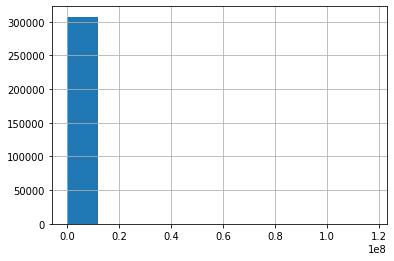

In [92]:
#소득이 1000000이하인 값 확인 
app_train['AMT_INCOME_TOTAL'].hist() #왼쪽으로 skewed

(array([3.07508e+05, 2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([2.56500000e+04, 1.17230850e+07, 2.34205200e+07, 3.51179550e+07,
        4.68153900e+07, 5.85128250e+07, 7.02102600e+07, 8.19076950e+07,
        9.36051300e+07, 1.05302565e+08, 1.17000000e+08]),
 <a list of 10 Patch objects>)

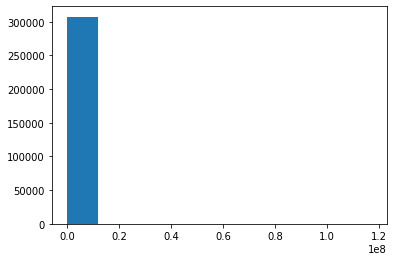

In [93]:
plt.hist(app_train['AMT_INCOME_TOTAL'])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


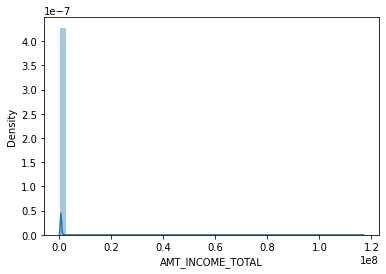

In [94]:
sns.distplot(app_train['AMT_INCOME_TOTAL'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


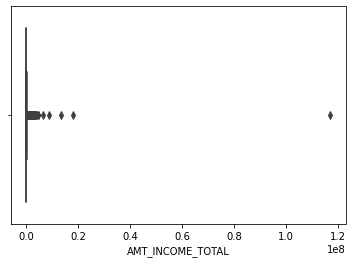

In [95]:
sns.boxplot(app_train['AMT_INCOME_TOTAL'])
#사분위 시각화로 확인
#오른쪽 이상치때문에 데이터 분포 확인 힘듬

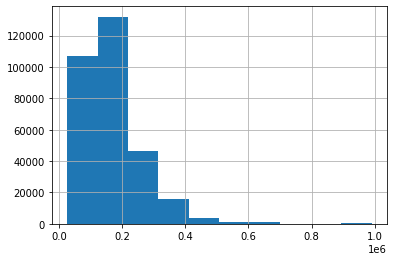

In [96]:
#1000000이하인 값들로 필터링(이상치 제거) 후 시각화 필요
cond_1=app_train['AMT_INCOME_TOTAL']<1000000
#booling index -> 데이터=[조건][확인 컬럼]
app_train[app_train['AMT_INCOME_TOTAL']<1000000]['AMT_INCOME_TOTAL'].hist()
#데이터들이 left skewed ,이산형 히스토그램

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


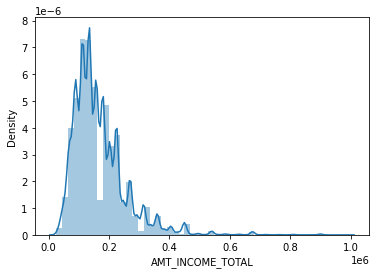

In [97]:
sns.distplot(app_train[cond_1]['AMT_INCOME_TOTAL'])
#연속형 히스토그램

#### TARGET 값에 따른 AMT_INCOME_TOTAL값 분포도 비교
* distplot과 violinplot 시각화
* plt.subplots() 기반으로 seaborn의 distplot과 violinplot으로 분포도 비교 시각화

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


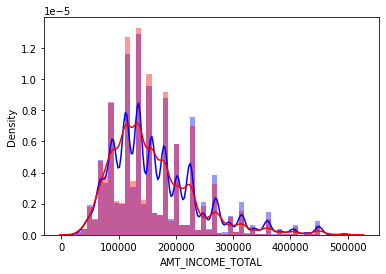

In [98]:
#타겟 값이 0,1 인지 조건에 따른 컬럼 값들의 분포 확인

#조건 설정
cond1=(app_train['TARGET']==1)
cond0=(app_train['TARGET']==0)
cond_amt=(app_train['AMT_INCOME_TOTAL']<500000)

#dist 로 그려야 겹쳐짐 dis 와 차이점?
sns.distplot(app_train[cond0 & cond_amt]['AMT_INCOME_TOTAL'],label='0',color='blue')

sns.distplot(app_train[cond1 & cond_amt]['AMT_INCOME_TOTAL'],label='1',color='red')

#빨간색 그래프는 연체 한 사람들 전체 수입 지표
#파란색 그래프는 연체 안한 사람들 전체 수입 지표

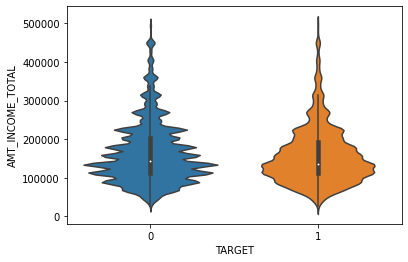

In [99]:
sns.violinplot(x='TARGET',y='AMT_INCOME_TOTAL',data=app_train[cond_amt])

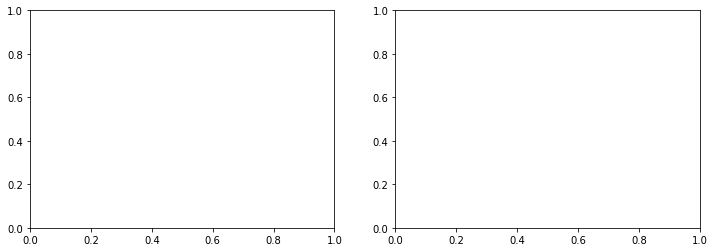

In [100]:
fig,axs=plt.subplots(figsize=(12,4),nrows=1,ncols=2) #서브 플롯의 열 행 지정 nrows,ncols

#fig 는 전체 axs 는 개별 그래프 컨트롤

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


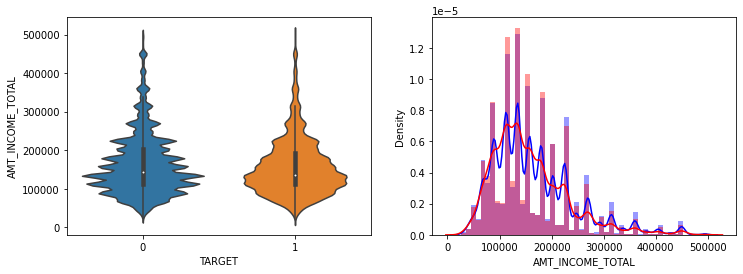

In [101]:
fig,axs=plt.subplots(figsize=(12,4),nrows=1,ncols=2,squeeze=False) #서브 플롯의 열 행 지정 nrows,ncols
#조건 설정
cond1=(app_train['TARGET']==1)
cond0=(app_train['TARGET']==0)
cond_amt=(app_train['AMT_INCOME_TOTAL']<500000)

sns.distplot(app_train[cond0 & cond_amt]['AMT_INCOME_TOTAL'],label='0',color='blue',ax=axs[0][1]) #ax (그래프 위치)=> axs의 위치넣어줌
sns.distplot(app_train[cond1 & cond_amt]['AMT_INCOME_TOTAL'],label='1',color='red',ax=axs[0][1])

sns.violinplot(x='TARGET',y='AMT_INCOME_TOTAL',data=app_train[cond_amt],ax=axs[0][0])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


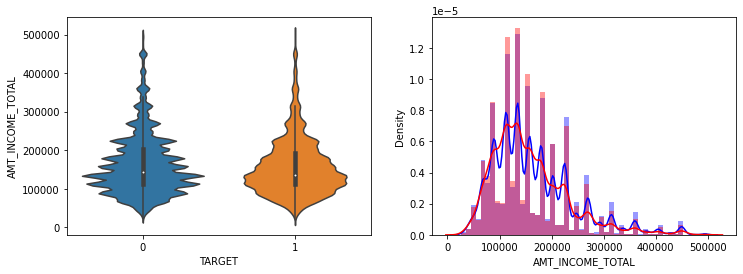

In [102]:
#위의 과정 함수화
def show_column_hist_by_target(df,columns,is_amt=False):
  cond1=(df['TARGET']==1)
  cond0=(df['TARGET']==0)

  fig,axs=plt.subplots(figsize=(12,4),nrows=1,ncols=2,squeeze=False)
  cond_amt=True
  if is_amt:
    cond_amt=df[columns]<500000 #만약cond_amt 조건이 맞다면 is_amt가 False 에서 True 로 바뀜
  sns.violinplot(x='TARGET',y=columns,data=df[cond_amt],ax=axs[0][0])
  sns.distplot(df[cond0 & cond_amt][columns],ax=axs[0][1],label='0',color='blue')
  sns.distplot(df[cond1 & cond_amt][columns],ax=axs[0][1],label='1',color='red')

show_column_hist_by_target(app_train,'AMT_INCOME_TOTAL',is_amt=True)  


#### app_train과 app_test를 합쳐서 한번에 데이터 preprocessing 수행. 

In [103]:
# train,test 분리해서 데이터 전처리 하면서 새로운 Feature 들을 만들면 똑같은 작업을 두번씩 해줘야함 
#그래서 train,test 합쳐서 데이터 전처리후 타겟의 유무로 분리해주면 됨

app_train.shape,app_test.shape

((307511, 122), (48744, 121))

In [104]:
#concat 합치려는 데이터 프레임을 리스트 형식으로 넣어줌
apps=pd.concat([app_train,app_test])
apps.shape


(356255, 122)

In [105]:
#테스트 데이터의 타겟값이 nan 으로 들어감
apps['TARGET'].value_counts(dropna=False)

0.0    282686
NaN     48744
1.0     24825
Name: TARGET, dtype: int64

#### Object feature들을 Label Encoding
* pandas의 factorize()를 이용

In [106]:
# Tree계열 LabelEncoding 과 onehotEncoding 비교? -> 돌려서 좋은걸 취해라 but 별차이는 없다

In [107]:
#데이터의 자료형 확인
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(66), int64(40), object(16)
memory usage: 334.3+ MB


In [108]:
#자료형이 object 인 컬럼들 
apps.dtypes[apps.dtypes=='object'].index.tolist() #우리에게 필요한건 object 타입인 컬럼 명 => index만 뽑은뒤 리스트로 변환
object_columns=apps.dtypes[apps.dtypes=='object']


In [109]:
#Label Encoding 역할
print(apps["CODE_GENDER"].value_counts())
#M,F,XNA 의 문자데이터를 0,1,2 로 인코딩
print(pd.factorize(apps['CODE_GENDER']))
print(pd.factorize(apps['CODE_GENDER'])[0]) #-> 인코딩된 결과
print(pd.factorize(apps['CODE_GENDER'])[1]) #-> 인코딩 전의 문자 데이터 정보

#우리는 인코딩 된 결과만 필요 하니까
apps['CODE_GENDER']=pd.factorize(apps['CODE_GENDER'])[0]

F      235126
M      121125
XNA         4
Name: CODE_GENDER, dtype: int64
(array([0, 1, 0, ..., 1, 0, 1]), Index(['M', 'F', 'XNA'], dtype='object'))
[0 1 0 ... 1 0 1]
Index(['M', 'F', 'XNA'], dtype='object')


In [110]:
#CODE GENDER 이 object 타입에서 int 타입으로 변한것을 확인할 수 있음 object ( 16 -> 15 )
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(66), int64(41), object(15)
memory usage: 334.3+ MB


In [111]:
object_columns=apps.dtypes[apps.dtypes=='object'].index.tolist()

for column in object_columns:
  apps[column]=pd.factorize(apps[column])[0]

#자료형이 모두 int 형으로 바뀐것 확인가능 == label encoding
apps.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(66), int64(56)
memory usage: 334.3 MB


#### Null값 일괄 변환

In [112]:
#비어있는 결측치 확인
apps.isnull().sum().head(100)

SK_ID_CURR                           0
TARGET                           48744
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         36
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                      0
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     235241
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

In [113]:
# -999로 모든 컬럼들의 Null값 변환
apps = apps.fillna(-999)

In [114]:
apps.isnull().sum().head(100)

SK_ID_CURR                      0
TARGET                          0
NAME_CONTRACT_TYPE              0
CODE_GENDER                     0
FLAG_OWN_CAR                    0
FLAG_OWN_REALTY                 0
CNT_CHILDREN                    0
AMT_INCOME_TOTAL                0
AMT_CREDIT                      0
AMT_ANNUITY                     0
AMT_GOODS_PRICE                 0
NAME_TYPE_SUITE                 0
NAME_INCOME_TYPE                0
NAME_EDUCATION_TYPE             0
NAME_FAMILY_STATUS              0
NAME_HOUSING_TYPE               0
REGION_POPULATION_RELATIVE      0
DAYS_BIRTH                      0
DAYS_EMPLOYED                   0
DAYS_REGISTRATION               0
DAYS_ID_PUBLISH                 0
OWN_CAR_AGE                     0
FLAG_MOBIL                      0
FLAG_EMP_PHONE                  0
FLAG_WORK_PHONE                 0
FLAG_CONT_MOBILE                0
FLAG_PHONE                      0
FLAG_EMAIL                      0
OCCUPATION_TYPE                 0
CNT_FAM_MEMBER

#### 학습 데이터와 테스트 데이터 다시 분리

In [115]:
#타겟값이 NULL 에서 -999로 바뀌었음
app_train=apps[apps['TARGET']!= -999]
app_test=apps[apps['TARGET']==-999]

print(app_train.shape)
print(app_test.shape)


(307511, 122)
(48744, 122)


In [116]:
#drop 의 inplace 옵션 디폴트 = False 명령어를 실행 한 후 메소드가 적용된 데이터 프레임을 기존 데이터 프레임으로 대체
#True이면,  명령어를 실행 한 후 메소드가 적용된 데이터 프레임으로 반환 -> 반환값은 컬럼이 삭제된 Dataframe이 된다. 
app_test=app_test.drop(['TARGET'],axis=1)

app_test.shape

(48744, 121)

#### 학습 데이터를 검증 데이터로 분리하고 LGBM Classifier로 학습 수행. 
* 피처용 데이터와 타겟 데이터 분리
* 학습용/검증용 데이터 세트 분리

In [117]:
#학습시 필요없는 데이터 컬럼 제외\
ftr_app=app_train.drop(['SK_ID_CURR','TARGET'],axis=1) 

#결과 데이터 
target_app=app_train['TARGET']


In [118]:
from sklearn.model_selection import train_test_split

train_x,valid_x,train_y,valid_y=train_test_split(ftr_app,target_app,test_size=0.3,random_state=42)

train_x.shape,valid_x.shape,train_y.shape,valid_y.shape

((215257, 120), (92254, 120), (215257,), (92254,))

In [119]:
from lightgbm import LGBMClassifier


clf = LGBMClassifier(
        n_jobs=-1,            #모든 프로세스 사용
        n_estimators=1000,    #1000번 반복
        learning_rate=0.02, 
        num_leaves=32,        #결과 leaf 32개
        subsample=0.8,
        max_depth=12,         #트리 높이가 최대 12
        silent=-1,
        verbose=-1
        )

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
eval_metric= 'auc', verbose= 100, early_stopping_rounds= 50) #50번 반복구간동안 성능 안좋아지면 early stop 

#810번째 early stopping valid_1's auc: 0.758896	

Training until validation scores don't improve for 50 rounds.
[100]	training's auc: 0.75225	training's binary_logloss: 0.250332	valid_1's auc: 0.740872	valid_1's binary_logloss: 0.251858
[200]	training's auc: 0.771524	training's binary_logloss: 0.243653	valid_1's auc: 0.751551	valid_1's binary_logloss: 0.247887
[300]	training's auc: 0.78527	training's binary_logloss: 0.239394	valid_1's auc: 0.755899	valid_1's binary_logloss: 0.246415
[400]	training's auc: 0.796899	training's binary_logloss: 0.235954	valid_1's auc: 0.757394	valid_1's binary_logloss: 0.245897
[500]	training's auc: 0.806535	training's binary_logloss: 0.233061	valid_1's auc: 0.75813	valid_1's binary_logloss: 0.245648
[600]	training's auc: 0.815212	training's binary_logloss: 0.230364	valid_1's auc: 0.758486	valid_1's binary_logloss: 0.245532
[700]	training's auc: 0.823391	training's binary_logloss: 0.227805	valid_1's auc: 0.758684	valid_1's binary_logloss: 0.24546
[800]	training's auc: 0.831119	training's binary_logloss: 0.

LGBMClassifier(learning_rate=0.02, max_depth=12, n_estimators=1000,
               num_leaves=32, silent=-1, subsample=0.8, verbose=-1)

##### Feature importance 시각화 

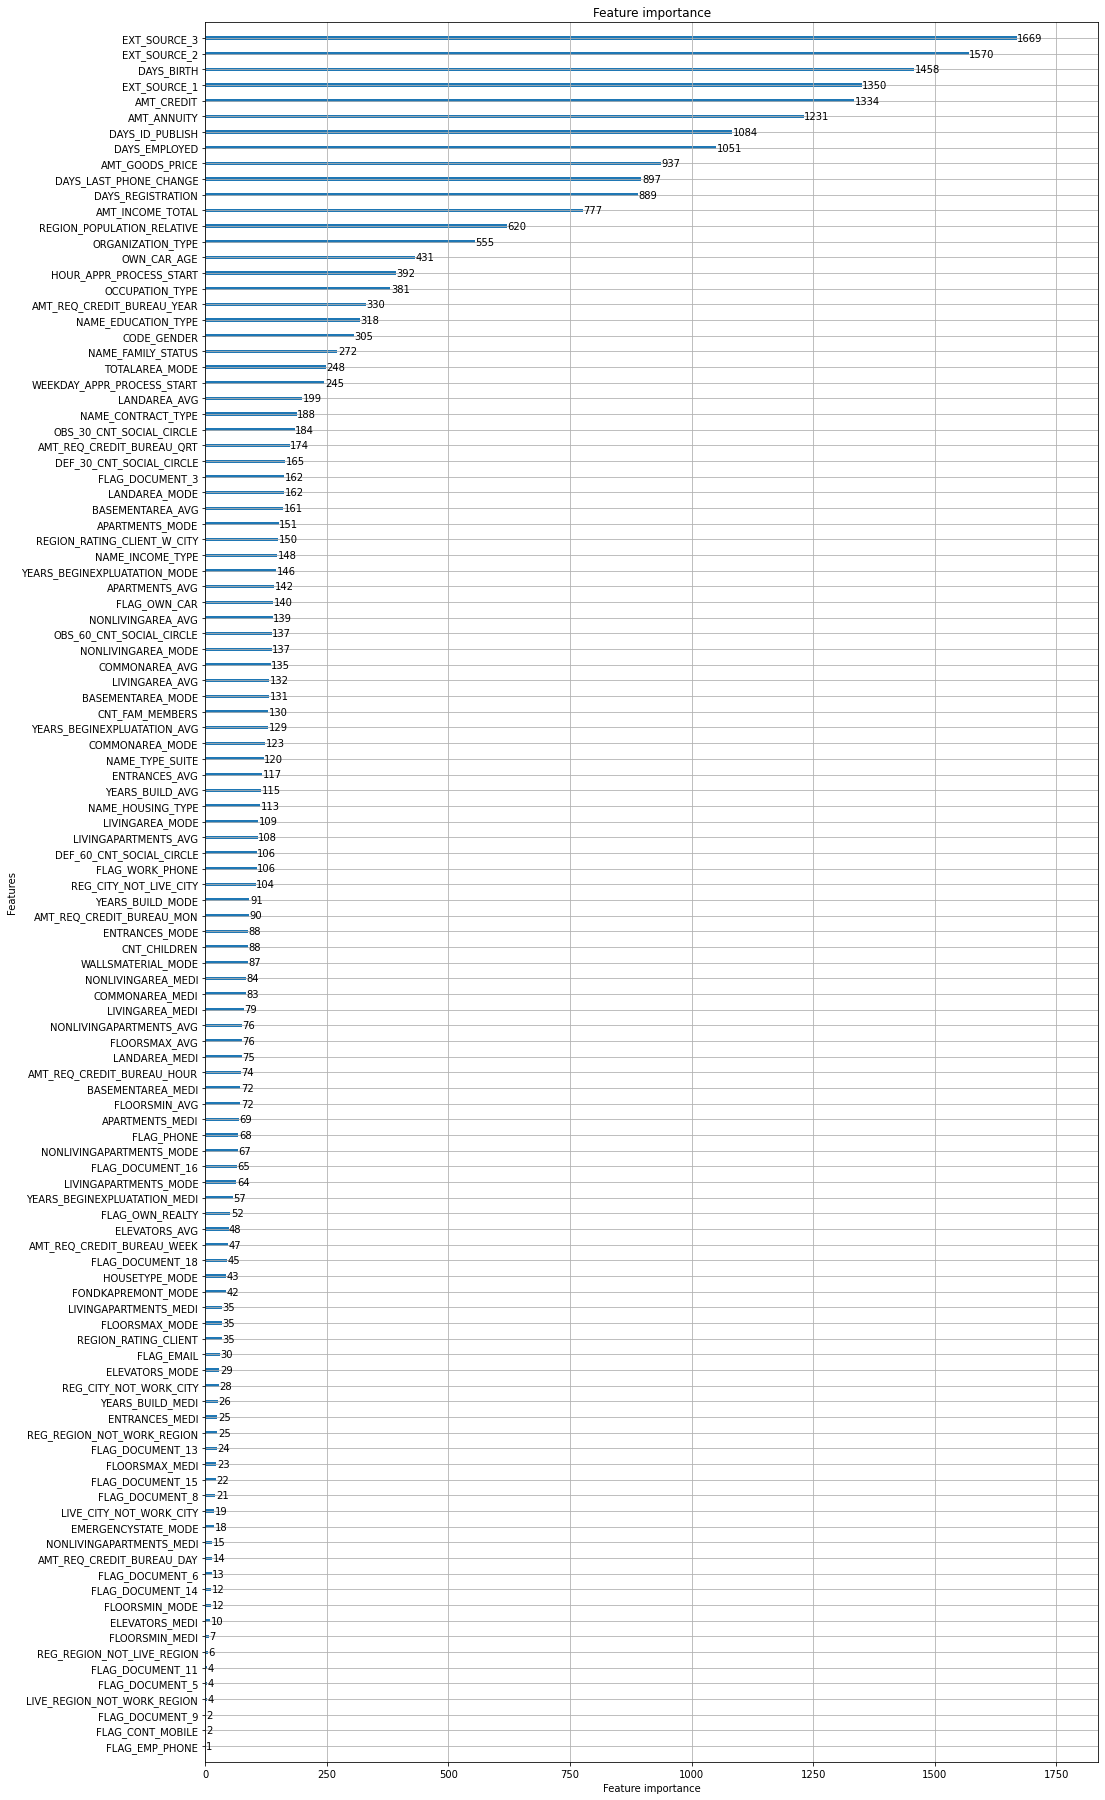

In [120]:
from lightgbm import plot_importance

#피쳐 중요도 / 쪼개지는 기준 EXT_SOURCE 계열의 피쳐가 주요 피쳐 
plot_importance(clf, figsize=(16, 32))

#### 학습된 Classifier를 이용하여 테스트 데이터을 예측하고 결과를 Kaggle로 Submit 수행. 

In [121]:
app_test_drop=app_test.drop(['SK_ID_CURR'],axis=1)

In [122]:
predict=clf.predict_proba(app_test_drop)
print(predict)

[[0.97029971 0.02970029]
 [0.88497527 0.11502473]
 [0.98249631 0.01750369]
 ...
 [0.96405974 0.03594026]
 [0.92878876 0.07121124]
 [0.82590368 0.17409632]]


In [123]:
preds=predict[:,1] #target 이 1 일때만 확률 담음

app_test['TARGET']=preds
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
0,100001,0,1,0,0,0,135000.0,568800.0,20560.5,450000.0,0,0,1,1,0,0.018850,-19241,-2329,-5170.0,-812,-999.0,1,1,0,1,0,1,-1,2.0,2,2,6,18,0,0,0,0,0,0,13,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,-999.0000,-999.0000,-999.00,0.1379,0.125,-999.0000,-999.0000,-999.0000,0.0505,-999.0000,-999.00,0.0672,0.0612,0.9732,-999.0000,-999.0000,-999.0000,0.1379,0.125,-999.0000,-999.0000,-999.0000,0.0526,-999.0000,-999.0000,0.0666,0.0590,0.9732,-999.0000,-999.0000,-999.00,0.1379,0.125,-999.0000,-999.0000,-999.0000,0.0514,-999.0000,-999.0000,-1,0,0.0392,0,0,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.029700
1,100005,0,0,0,0,0,99000.0,222768.0,17370.0,180000.0,0,0,0,1,0,0.035792,-18064,-4469,-9118.0,-1623,-999.0,1,1,0,1,0,0,13,2.0,2,2,5,9,0,0,0,0,0,0,9,0.564990,0.291656,0.432962,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.00,-999.0000,-999.000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.00,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.00,-999.0000,-999.000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-1,-1,-999.0000,-1,-1,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,0.115025
2,100013,0,0,1,0,0,202500.0,663264.0,69777.0,630000.0,-1,0,1,1,0,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,4,2.0,2,2,1,14,0,0,0,0,0,0,25,-999.000000,0.699787,0.610991,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.00,-999.0000,-999.000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.00,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-

In [124]:
app_test[['SK_ID_CURR','TARGET']].to_csv('baseline_01.csv',index=False)

##### 코랩 버전은 Google Drive로 예측 결과 CSV를 생성.

In [125]:
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [126]:
# SK_ID_CURR과 TARGET 값만 csv 형태로 생성. 코랩 버전은 구글 드라이브 절대 경로로 입력  
default_dir = "/content/gdrive/My Drive"
app_test[['SK_ID_CURR', 'TARGET']].to_csv(os.path.join(default_dir, 'app_baseline_01.csv'), index=False)

In [ ]:
!ls "/content/gdrive/My Drive"